In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [ ]:
df= pd.read_csv("/content/sample_data/Walmart (1).csv")

In [ ]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
df.columns = [c.strip() for c in df.columns]

In [ ]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,weekofyear
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,6.447552,25.818182
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,1.000000,1.000000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,14.000000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,6.000000,26.000000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,9.000000,38.000000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,12.000000,52.000000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,3.238308,14.129201


In [ ]:
df.isnull().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0
month,0
weekofyear,0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.sort_values(by=['Store', 'Date'], inplace=True)

In [ ]:
#  Missing values
missing_summary = df.isna().sum().to_frame('missing_count')
missing_summary['missing_pct'] = missing_summary['missing_count'] / len(df) * 100

In [ ]:
# Impute numeric columns per-store median if needed
num_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']
for col in num_cols:
    if df[col].isna().any():
        df[col] = df.groupby('Store')[col].apply(lambda g: g.fillna(g.median()))
        # if still NA (store all NA), fill with global median
        df[col] = df[col].fillna(df[col].median())

In [ ]:
# 3. Outlier detection per store for Weekly_Sales using IQR
def detect_iqr_outliers(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return ((s < lower) | (s > upper)).sum(), lower, upper

outlier_info = []
for store, g in df.groupby('Store'):
    cnt, lo, hi = detect_iqr_outliers(g['Weekly_Sales'])
    outlier_info.append({'Store': store, 'outlier_count': int(cnt), 'iqr_lower': float(lo), 'iqr_upper': float(hi), 'n_records': len(g)})
outlier_df = pd.DataFrame(outlier_info).sort_values('outlier_count', ascending=False)


In [ ]:
# 4. Correlations per store (Pearson) between Weekly_Sales and Unemployment, CPI, Temperature
corrs = []
for store, g in df.groupby('Store'):
    corr_unemp = g['Weekly_Sales'].corr(g['Unemployment'])
    corr_cpi = g['Weekly_Sales'].corr(g['CPI'])
    corr_temp = g['Weekly_Sales'].corr(g['Temperature'])
    corrs.append({'Store': store, 'corr_unemployment': corr_unemp, 'corr_CPI': corr_cpi, 'corr_temperature': corr_temp, 'n': len(g)})
corr_df = pd.DataFrame(corrs).sort_values('corr_unemployment')  # sort by unemployment corr (most negative first)

In [ ]:
# 5. Identify top 5 stores by average weekly sales for forecasting
store_stats = df.groupby('Store')['Weekly_Sales'].agg(['mean','median','sum','count']).reset_index().rename(columns={'mean':'avg_weekly_sales'})
top5 = store_stats.sort_values('avg_weekly_sales', ascending=False).head(5)
top5_list = top5['Store'].tolist()


In [ ]:
# 6. Seasonality analysis: average sales by month and by weekofyear (overall & top5)
df['month'] = df['Date'].dt.month
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)

monthly_avg_overall = df.groupby('month')['Weekly_Sales'].mean().reset_index()
weekly_avg_overall = df.groupby('weekofyear')['Weekly_Sales'].mean().reset_index()

monthly_top5 = df[df['Store'].isin(top5_list)].groupby(['Store','month'])['Weekly_Sales'].mean().reset_index()
weekly_top5 = df[df['Store'].isin(top5_list)].groupby(['Store','weekofyear'])['Weekly_Sales'].mean().reset_index()

In [ ]:
# 7. Forecasting for each top5 store
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing

forecasts = []
models_info = []

for store in top5_list:
    g = df[df['Store'] == store].copy().sort_values('Date')
    # Ensure Date is datetime
    g['Date'] = pd.to_datetime(g['Date'])
    g = g.set_index('Date').sort_index()




In [ ]:
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import pandas as pd

forecasts = []
models_info = []

for store in top5_list:
    g = df[df['Store'] == store].copy().sort_values('Date')
    # Ensure Date is datetime
    g['Date'] = pd.to_datetime(g['Date'])
    g = g.set_index('Date').sort_index()


In [ ]:
    # Create a continuous weekly index (W-SAT) from min to max date
    full_idx = pd.date_range(start=g.index.min(), end=g.index.max(), freq='W-SAT')
    series = g['Weekly_Sales'].reindex(full_idx)  # may introduce NaNs where weeks are missing

In [ ]:

    # Interpolate missing weeks by time (only where there are gaps)
    series = series.interpolate(method='time')


In [ ]:

    # Final safety-fill: backward then forward fill to avoid any remaining NaNs
    series = series.bfill().ffill()

In [ ]:
    # If the series is all NaN or too short, skip forecasting
    if series.isna().all() or len(series.dropna()) < 10:
        fc_idx = pd.date_range(start=full_idx.max() + pd.Timedelta(7, unit='D'), periods=12, freq='W-SAT')
        fc = pd.Series([np.nan])


In [ ]:
# 8. Display key tables and plots

print("\n=== Missing Value Summary ===")
display(missing_summary.reset_index().rename(columns={'index':'column'}))




=== Missing Value Summary ===


,column,missing_count,missing_pct
0,Store,0,0.0
1,Date,0,0.0
2,Weekly_Sales,0,0.0
3,Holiday_Flag,0,0.0
4,Temperature,0,0.0
5,Fuel_Price,0,0.0
6,CPI,0,0.0
7,Unemployment,0,0.0


In [ ]:
print("\n=== Top 5 Stores by Average Weekly Sales ===")
display(top5)



=== Top 5 Stores by Average Weekly Sales ===


,Store,avg_weekly_sales,median,sum,count
19,20,2.107677e+06,2053165.41,3.013978e+08,143
3,4,2.094713e+06,2073951.38,2.995440e+08,143
13,14,2.020978e+06,2004330.30,2.889999e+08,143
12,13,2.003620e+06,1958823.56,2.865177e+08,143
1,2,1.925751e+06,1879107.31,2.753824e+08,143


In [ ]:
print("\n=== Per-Store Correlation (Weekly_Sales vs Unemployment/CPI/Temperature) - sorted by unemployment corr ===")
display(corr_df.sort_values('corr_unemployment').head(10))


=== Per-Store Correlation (Weekly_Sales vs Unemployment/CPI/Temperature) - sorted by unemployment corr ===


,Store,corr_unemployment,corr_CPI,corr_temperature,n
37,38,-0.785290,0.812837,0.032993,143
43,44,-0.780076,0.740150,0.267822,143
38,39,-0.384681,0.428043,0.064738,143
41,42,-0.356355,0.360859,-0.151639,143
40,41,-0.350630,0.392293,0.106761,143
3,4,-0.337015,0.351157,-0.225583,143
16,17,-0.263600,0.348571,0.081012,143
2,3,-0.230413,0.317250,-0.377524,143
36,37,-0.221287,0.244507,-0.300493,143
4,5,-0.207043,0.308261,-0.175517,143


In [ ]:

print("\n=== Outlier Counts per Store (IQR method) - top 10 ===")
display(outlier_df.head(10))



=== Outlier Counts per Store (IQR method) - top 10 ===


,Store,outlier_count,iqr_lower,iqr_upper,n_records
21,22,14,8.242887e+05,1.190122e+06,143
24,25,12,5.595919e+05,8.153058e+05,143
7,8,11,7.462320e+05,1.038695e+06,143
17,18,10,8.004388e+05,1.334146e+06,143
19,20,10,1.644385e+06,2.461667e+06,143
33,34,10,8.312270e+05,1.068591e+06,143
28,29,9,4.080917e+05,6.384104e+05,143
13,14,9,1.494575e+06,2.504503e+06,143
29,30,9,3.875287e+05,4.903067e+05,143
9,10,9,1.435762e+06,2.249120e+06,143


In [ ]:
print("\n=== Stores most negatively correlated with Unemployment ===")
most_affected_by_unemp = corr_df.sort_values('corr_unemployment').head(5)[['Store','corr_unemployment']].reset_index(drop=True)
display(most_affected_by_unemp)



=== Stores most negatively correlated with Unemployment ===


,Store,corr_unemployment
0,38,-0.785290
1,44,-0.780076
2,39,-0.384681
3,42,-0.356355
4,41,-0.350630


In [ ]:
print("\n=== Sample Forecasts (first 50 rows) ===")
display(forecast_all.head(50))


=== Sample Forecasts (first 50 rows) ===


,Date,Forecast_Weekly_Sales,Store
0,2012-10-27,NaN,20
1,2012-11-03,NaN,20
2,2012-11-10,NaN,20
3,2012-11-17,NaN,20
4,2012-11-24,NaN,20
5,2012-12-01,NaN,20
6,2012-12-08,NaN,20
7,2012-12-15,NaN,20
8,2012-12-22,NaN,20
9,2012-12-29,NaN,20


In [ ]:
# Optionally save the forecasts
OUT_PATH = "/content/walmart_top5_12week_forecasts.csv"  # change path if needed
forecast_all.to_csv(OUT_PATH, index=False)
print(f"\nForecast file saved to: {OUT_PATH}")



Forecast file saved to: /content/walmart_top5_12week_forecasts.csv


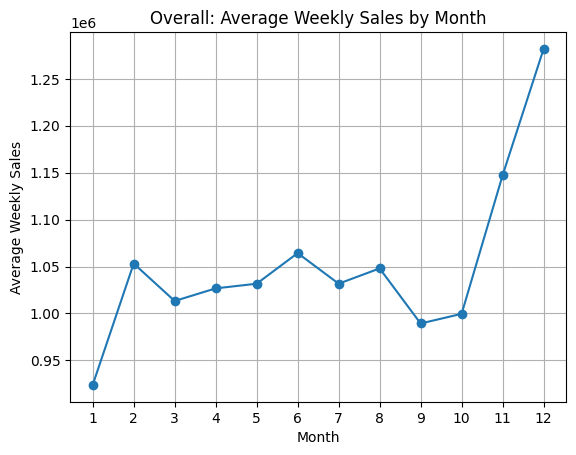

In [ ]:
# Plots: overall monthly avg
plt.figure()
plt.plot(monthly_avg_overall['month'], monthly_avg_overall['Weekly_Sales'], marker='o')
plt.title('Overall: Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()


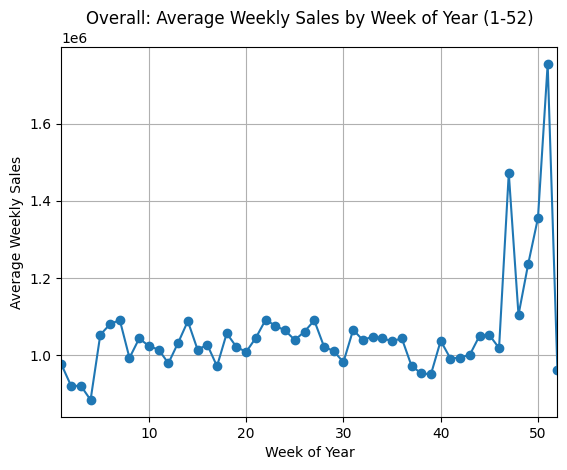

In [ ]:
# Plot weekly average overall (weekofyear)
plt.figure()
plt.plot(weekly_avg_overall['weekofyear'], weekly_avg_overall['Weekly_Sales'], marker='o')
plt.title('Overall: Average Weekly Sales by Week of Year (1-52)')
plt.xlabel('Week of Year')
plt.ylabel('Average Weekly Sales')
plt.xlim(1,52)
plt.grid(True)
plt.show()


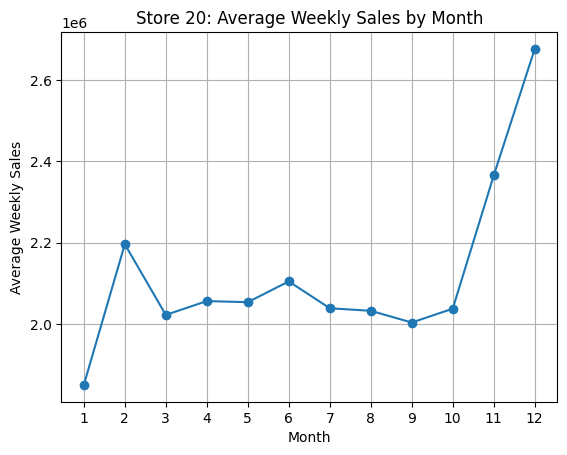

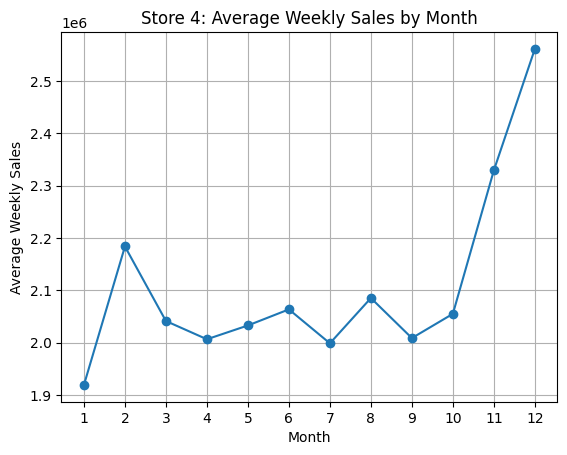

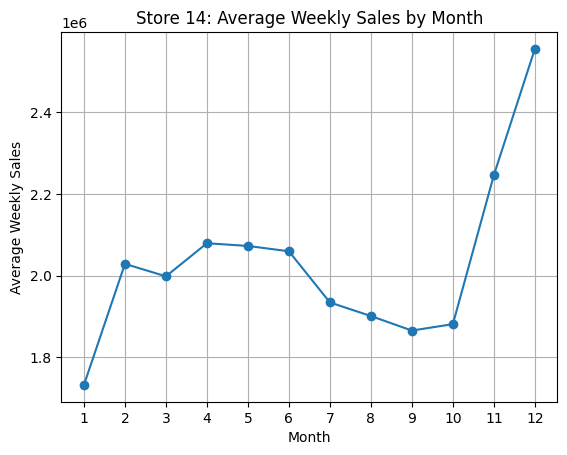

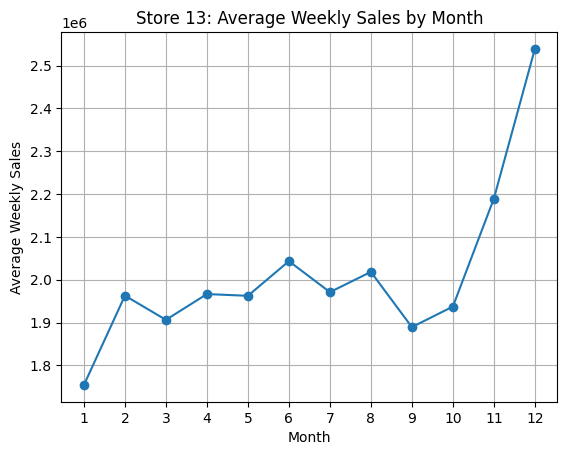

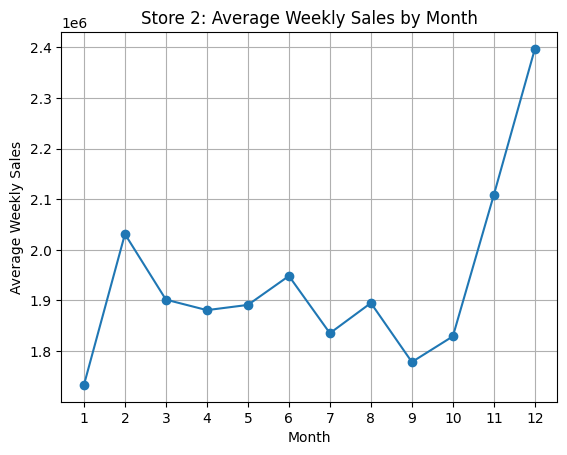

In [ ]:
# Plot monthly avg for each top5 store (one plot per store)
for store in top5_list:
    d = monthly_top5[monthly_top5['Store']==store]
    plt.figure()
    plt.plot(d['month'], d['Weekly_Sales'], marker='o')
    plt.title(f'Store {store}: Average Weekly Sales by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Weekly Sales')
    plt.xticks(range(1,13))
    plt.grid(True)
    plt.show()

In [ ]:
# Show forecast sample table
("Sample Forecasts (first 50 rows)", forecast_all.head(50))

('Sample Forecasts (first 50 rows)',
          Date  Forecast_Weekly_Sales  Store
 0  2012-10-27                    NaN     20
 1  2012-11-03                    NaN     20
 2  2012-11-10                    NaN     20
 3  2012-11-17                    NaN     20
 4  2012-11-24                    NaN     20
 5  2012-12-01                    NaN     20
 6  2012-12-08                    NaN     20
 7  2012-12-15                    NaN     20
 8  2012-12-22                    NaN     20
 9  2012-12-29                    NaN     20
 10 2013-01-05                    NaN     20
 11 2013-01-12                    NaN     20
 12 2012-10-27                    NaN      4
 13 2012-11-03                    NaN      4
 14 2012-11-10                    NaN      4
 15 2012-11-17                    NaN      4
 16 2012-11-24                    NaN      4
 17 2012-12-01                    NaN      4
 18 2012-12-08                    NaN      4
 19 2012-12-15                    NaN      4
 20 2012-12-22    

In [ ]:
from IPython.display import display


# Identify stores most negatively correlated with Unemployment
print("\n=== Stores most negatively correlated with Unemployment ===")
most_affected_by_unemp = corr_df.sort_values('corr_unemployment').head(5)[['Store', 'corr_unemployment']].reset_index(drop=True)
display(most_affected_by_unemp)



=== Stores most negatively correlated with Unemployment ===


,Store,corr_unemployment
0,38,-0.785290
1,44,-0.780076
2,39,-0.384681
3,42,-0.356355
4,41,-0.350630


In [ ]:

print("\n=== Sample Forecasts (first 50 rows) ===")
display(forecast_all.head(50))


=== Sample Forecasts (first 50 rows) ===


,Date,Forecast_Weekly_Sales,Store
0,2012-10-27,NaN,20
1,2012-11-03,NaN,20
2,2012-11-10,NaN,20
3,2012-11-17,NaN,20
4,2012-11-24,NaN,20
5,2012-12-01,NaN,20
6,2012-12-08,NaN,20
7,2012-12-15,NaN,20
8,2012-12-22,NaN,20
9,2012-12-29,NaN,20


In [ ]:
# Save forecasts to file
OUT_PATH = "walmart_top5_12week_forecasts.csv"  # adjust path as needed
forecast_all.to_csv(OUT_PATH, index=False)
print(f"\nForecast file saved to: {OUT_PATH}")


Forecast file saved to: walmart_top5_12week_forecasts.csv


In [ ]:

# final summary dataframe to show key takeaways
# Identify stores most negatively correlated with unemployment (lowest correlation values)
most_affected_by_unemp = corr_df.sort_values('corr_unemployment').head(5)[['Store','corr_unemployment']].reset_index(drop=True)
print("Stores most negatively correlated with Unemployment (may be suffering when unemployment rises):")
display(most_affected_by_unemp)


print(f"Forecast file saved to: {OUT_PATH}")

Stores most negatively correlated with Unemployment (may be suffering when unemployment rises):


,Store,corr_unemployment
0,38,-0.785290
1,44,-0.780076
2,39,-0.384681
3,42,-0.356355
4,41,-0.350630


Forecast file saved to: walmart_top5_12week_forecasts.csv
